<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-mulearn.fuzzifier-module" data-toc-modified-id="The-mulearn.fuzzifier-module-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The <code>mulearn.fuzzifier</code> module</a></span></li></ul></div>

# The `mulearn.fuzzifier` module 

> The `mulearn.fuzzifier` module contains the implementations of fuzzifiers.

In [ ]:
# export

import numpy as np
import matplotlib.pyplot as plt
import pytest
from scipy.optimize import curve_fit

In [ ]:
# default_exp fuzzifier

In [ ]:
#hide
from nbdev.showdoc import show_doc

In [ ]:
# export

class Fuzzifier:
    def __init__(self, xs=None, mus=None):
        self.xs = xs
        self.mus = mus

    def get_r_to_mu(self,
                    sq_radius, # was SV_square_distance
                    x_to_sq_dist): # was estimated_square_distance_from_center
        '''Transforms the square distance between center of the learnt sphere
        and the image of a point in original space into the membership degree
        of the latter to the induced fuzzy set.
        
        Not implemented in the base fuzzifier class.
        
        - `sq_radius`: squared radius of the learnt sphere (float).
        
        - `x_to_sq_dist`: mapping of a point in original space into the
          square distance of its image from the center of the learnt sphere
          (function).
        '''
        
        raise NotImplementedError(
        'the base class does not implement get_r_to_mu method')

    def get_membership(self,
                                 sq_radius, # was SV_square_distance
                                 x_to_sq_dist, # was estimated_square_distance_from_center
                                 return_profile=False):
        '''Return the induced membership function.
        
        - `sq_radius`: squared radius of the learnt sphere (float).
        
        - `x_to_sq_dist`: mapping of a point in original space into the
          square distance of its image from the center of the learnt sphere
          (function).
        
        - `return_profile` flag triggering the generation of the graph
          of the fuzzifier to be returned alongside the fuzzifier itself
          (bool, default=False).

        Returns a list containing
        
        - the membership function if `return_profile` is `False`, and
        - the membership function and the salient coordinates of the graph of
          the fuzzifier if `return_profile` is `True`.
        '''
        r_to_mu = self.get_r_to_mu(sq_radius, x_to_sq_dist)
        
        def estimated_membership(x):
            r = x_to_sq_dist(np.array(x))
            return r_to_mu(r)

        result = [estimated_membership]

        if return_profile:
            rdata = list(map(x_to_sq_dist, self.xs))
            rdata_synth = np.linspace(0, max(rdata)*1.1, 200)
            estimate = list(map(r_to_mu, rdata_synth))
            result.append([rdata, rdata_synth, estimate])

        return result
    
    def __str__(self):
        return self.__repr__()

    def __eq__(self, other):
        return type(self) == type(other)

    def __ne__(self, other):
        return not self == other

    def __hash__(self):
        return hash(self.__repr__())

    def __nonzero__(self):
        return True

The base class for fuzzifiers is `Fuzzifier`: it exposes a basic constructor
which is called from the subclasses, and two methods `get_r_to_mu` returning
a mapping that transforms a point from the original space onto the feature
space, subsequently computing the distance of the image w.r.t. the center
of the learnt sphere, and `get_membership` returning the membership
function inferred from data, possibly alongside informations enabling to
draw the graph of the fuzzifier.

In [ ]:
# export

class CrispFuzzifier(Fuzzifier):
    def __init__(self, xs=None, mus=None, profile='fixed'):
        r'''Creates an instance of `CrispFuzzifier`
        
        - `xs`: objects in training set (iterable).
        
        - `mus`: degree memberships in training set (iterable).
        
        - `profile`: method to be used in order to fix the fuzzifier
          threshold ('fixed' used the sphere radius, 'infer' fits using
          data in `self.xs` and `self.mus`).
        '''
        
        super().__init__(xs, mus)
        self.profile = profile
        if profile not in ['fixed', 'infer']:
            raise ValueError(f"'profile' parameter should be equal to "
                             "'fixed' or 'infer' (provided value: {profile})")
            
        if profile == 'infer' and (xs is None or mus is None):
            raise ValueError(f"all arguments to the constructor of "
                             "CrispFuzzifier should be specified when "
                             "profile='infer'")

        self.name = 'Crisp'
        self.latex_name = '$\\hat\\mu_{\\text{crisp}}$'

    def get_r_to_mu(self, sq_radius, x_to_sq_dist):
        r'''Returns a function that transforms the square distance between
        center of the learnt sphere and the image of a point in original
        space into a crisp membership degree having the form
        
        $$ \mu(r) = \begin{cases}
          1 & \text{if $r \leq r_\text{crisp}$,} \\
          0 & \text{otherwise.}
        \end{cases}$$   
        
        The threshold is set to the learnt square radius of the sphere if the
        `profile` attribute of the class have been set to `fixed`, and
        induced via interpolation of the `xs` and `mus` attributes when it is
        has been set to `infer`.
        
        **Note** This function is meant to be called internally by the
        `get_membership` method in the base `Fuzzifier` class.
        
        - `sq_radius`: squared radius of the learnt sphere (float).
        
        - `x_to_sq_dist`: mapping of a point in original space into the
          square distance of its image from the center of the learnt sphere
          (function).
        '''
        
        if self.profile == 'fixed':
            return lambda r: 1 if r <= sq_radius else 0
            
        elif self.profile == 'infer':
            rdata = np.fromiter(map(x_to_sq_dist, self.xs), dtype=float)

            def r_to_mu_prototype(r, r_crisp):
                result = np.ones(len(r))
                result[r > r_crisp] = 0
                return result


            popt, _ = curve_fit(r_to_mu_prototype, rdata, self.mus)
                                # bounds=((0,), (np.inf,)))

            if popt[0] < 0:
                raise ValueError('Profile fitting returned a negative parameter')
            return lambda r: r_to_mu_prototype([r], *popt)[0]
        else:
            raise ('This should never happen. '
                   'Check CrispFuzzifier constructor.')

    def __repr__(self):
        xs_repr = self.xs.__repr__()
        mus_repr = self.mus.__repr__()
        self_repr = f'CrispFuzzifier({xs_repr}, {mus_repr}'
        if self.profile != 'fixed':
            self_repr += f', profile={self.profile}'
        self_repr += ')'
        return self_repr

Fuzzifier corresponding to a crisp (classical) set: membership is equal to 1
within the learnt sphere and equal to 0 outside it.

In [ ]:
show_doc(CrispFuzzifier.__init__)

<h4 id="CrispFuzzifier.__init__" class="doc_header"><code>CrispFuzzifier.__init__</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>CrispFuzzifier.__init__</code>(**`xs`**=*`None`*, **`mus`**=*`None`*, **`profile`**=*`'fixed'`*)

Creates an instance of [`CrispFuzzifier`](/mulearn/fuzzifiers#CrispFuzzifier)

- `xs`: objects in training set (iterable).

- `mus`: degree memberships in training set (iterable).

- `profile`: method to be used in order to fix the fuzzifier
  threshold ('fixed' used the sphere radius, 'infer' fits using
  data in `self.xs` and `self.mus`).

A crisp fuzzifier can be created etiher without arguments or specifying
objects and labels of a training set.

In [ ]:
cf_1 = CrispFuzzifier()
cf_2 = CrispFuzzifier([1, 2, 5, 5.5, 7, 8, 9.5, 10],
                      [1, 1, 1, 0.9, 0.4, 0.1, 0, 0])

The optional parameter `profile` defines the procedure to be used in order
to choose the thresholding value in the fuzzifier, it can either be set to
`'fixed'` or `'infer'` (see the description of `get_r_to_mu` later on).
Specifying a different value will raise an exception. The same will happen
if `profile='infer'` and the training set has not been specified as argument
to the constructor.

In [ ]:
show_doc(CrispFuzzifier.get_r_to_mu)

<h4 id="CrispFuzzifier.get_r_to_mu" class="doc_header"><code>CrispFuzzifier.get_r_to_mu</code><a href="__main__.py#L30" class="source_link" style="float:right">[source]</a></h4>

> <code>CrispFuzzifier.get_r_to_mu</code>(**`sq_radius`**, **`x_to_sq_dist`**)

Returns a function that transforms the square distance between
center of the learnt sphere and the image of a point in original
space into a crisp membership degree having the form

$$ \mu(r) = \begin{cases}
  1 & \text{if $r \leq r_\text{crisp}$,} \\
  0 & \text{otherwise.}
\end{cases}$$   

The threshold is set to the learnt square radius of the sphere if the
`profile` attribute of the class have been set to `fixed`, and
induced via interpolation of the `xs` and `mus` attributes when it is
has been set to `infer`.

**Note** This function is meant to be called internally by the
`get_membership` method in the base [`Fuzzifier`](/mulearn/fuzzifiers#Fuzzifier) class.

- `sq_radius`: squared radius of the learnt sphere (float).

- `x_to_sq_dist`: mapping of a point in original space into the
  square distance of its image from the center of the learnt sphere
  (function).

In [ ]:
show_doc(CrispFuzzifier.get_membership)

<h4 id="Fuzzifier.get_membership" class="doc_header"><code>Fuzzifier.get_membership</code><a href="__main__.py#L27" class="source_link" style="float:right">[source]</a></h4>

> <code>Fuzzifier.get_membership</code>(**`sq_radius`**, **`x_to_sq_dist`**, **`return_profile`**=*`False`*)

Return the induced membership function.

- `sq_radius`: squared radius of the learnt sphere (float).

- `x_to_sq_dist`: mapping of a point in original space into the
  square distance of its image from the center of the learnt sphere
  (function).

- `return_profile` flag triggering the generation of the graph
  of the fuzzifier to be returned alongside the fuzzifier itself
  (bool, default=False).

Returns a list containing

- the membership function if `return_profile` is `False`, and
- the membership function and the salient coordinates of the graph of
  the fuzzifier if `return_profile` is `True`.

`CrispFuzzifier` implements this method in order to return a threshold
function. The thresholding value is fixed by default using the radius of
the learnt sphere.

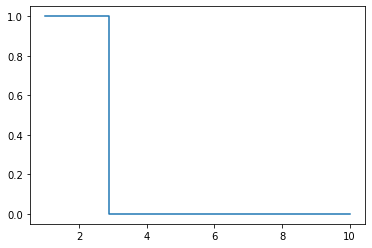

In [ ]:
cf = CrispFuzzifier([1, 2, 5, 5.5, 7, 8, 9.5, 10],
                    [1, 1, 1, 0.9, 0.4, 0.1, 0, 0])
[mu] = cf.get_membership(1, lambda x: x/3)

x = np.linspace(1, 10, 20)
plt.step(x, list(map(mu, x)))
plt.show()

Setting `profile='infer'` will perform an interpolation process fitting
the threshold to the training set passed to the constructor.

/home/malchiodi/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


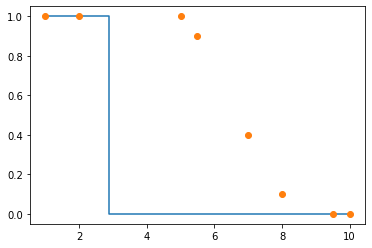

In [ ]:
xs = [1, 2, 5, 5.5, 7, 8, 9.5, 10]
mus = [1, 1, 1, 0.9, 0.4, 0.1, 0, 0]
cf = CrispFuzzifier(xs,mus, profile='infer')
[mu] = cf.get_membership(2, lambda x: x/3)

x = np.linspace(1, 10, 20)
plt.step(x, list(map(mu, x)))
plt.plot(xs, mus, 'o')
plt.show()

The `return_profile` optional argument returns a further list that contains
- a list of the squared distances between the images of points in the
  training set and the center of the sphere;
- a list of synthesized values for such distances (spanned uniformely
  between the minimum and maximum values of the distances within the
  training set);
- a list of membership values associated to the values in previous point.

This new information allow for drawing a profile of the membership function
as a function of the distance in feature space.

/home/malchiodi/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


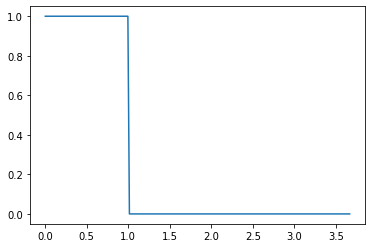

In [ ]:
[mu, [rdata, rdata_synth, estimate]] = \
      cf.get_membership(1, lambda x: x/3, return_profile=True)

plt.plot(rdata_synth, estimate)
plt.show()

**Tests**

In [ ]:
with pytest.raises(ValueError):
    cf = CrispFuzzifier(profile='infer')
    
with pytest.raises(ValueError):
    cr = CrispFuzzifier(profile='xxx')

In [ ]:
#export

class LinearFuzzifier(Fuzzifier):
    def __init__(self, xs=None, mus=None, profile='fixed'):
        r'''Creates an instance of `LinearFuzzifier`
        
        - `xs`: objects in training set (iterable).
        
        - `mus`: degree memberships in training set (iterable).
        
        - `profile`: method to be used in order to fix the fuzzifier
          threshold ('fixed' used the sphere radius, 'infer' fits using
          data in `self.xs` and `self.mus`).
        '''
        
        super().__init__(xs, mus)
        
        if profile not in ['fixed', 'infer']:
            raise ValueError(f"'profile' parameter should be equal to "
                             "'fixed' or 'infer' (provided value: {profile})")
            
        if profile == 'infer' and (xs is None or mus is None):
            raise ValueError(f"all arguments to the constructor of "
                             "LinearFuzzifier should be specified when "
                             "profile='infer'")
            
        self.profile = profile
        
        self.name = 'Linear'
        self.latex_name = '$\\hat\\mu_{\\text{lin}}$'
        

    def get_r_to_mu(self,
                    sq_radius, # was SV_square_distance
                    x_to_sq_dist): #was estimated_square_distance_from_center
        r'''Returns a function that transforms the square distance between
        center of the learnt sphere and the image of a point in original
        space into a membership degree having the form
        
        $$ \mu(r) = \begin{cases}
          1    & \text{if $r \leq r_\text{crisp}$,} \\
          l(r) & \text{otherwise,}
        \end{cases}$$   
        
        where $l$ is a linear function decreasing from 1 to 0. The slope of
        this linear function is chosen so that the latter contains the point
        (sq_radius, 0.5) if the `profile` attribute of the class
        have been set to `fixed`, and induced via interpolation of the `xs`
        and `mus` attributes when it is has been set to `infer`.
        
        **Note** This function is meant to be called internally by the
        `get_membership` method in the base `Fuzzifier` class.
        
        - `sq_radius`: squared radius of the learnt sphere (float).
        
        - `x_to_sq_dist`: mapping of a point in original space into the
          square distance of its image from the center of the learnt sphere
          (function).
        '''

        rdata = np.fromiter(map(x_to_sq_dist, self.xs), dtype=float)

        r_1_guess = np.median([x_to_sq_dist(x)
                               for x, mu in zip(self.xs, self.mus)
                               if mu>=0.99])
            
        if self.profile == 'fixed':
            def r_to_mu_prototype(r, r_1):
                return [np.clip(1 - 0.5 * (rr-r_1) / (sq_radius - r_1), 0, 1)
                        for rr in r]

            popt, _ = curve_fit(r_to_mu_prototype,
                                rdata, self.mus,
                                p0=(r_1_guess,),
                                bounds=((0,), (np.inf,)))
            
        elif self.profile == 'infer':
            
            def r_to_mu_prototype(r, r_1, r_0):
                return [np.clip(1 - (r_1 - rr) / (r_1 - r_0), 0, 1)
                        for rr in r]

            popt, _ = curve_fit(r_to_mu_prototype,
                                rdata, self.mus,
                                p0=(r_1_guess, 10*sq_radius),
                                bounds=((0, 0), (np.inf, np.inf,)))
        else:
            raise ValueError('This should never happen.'
                             ' Check LinearFuzzifier constructor.')
        if min(popt) < 0:
            raise ValueError('Profile fitting returned a negative parameter')

        return lambda r: r_to_mu_prototype([r], *popt)[0]


    def __repr__(self):
        xs_repr = self.xs.__repr__()
        mus_repr = self.mus.__repr__()
        self_repr = f'LinearFuzzifier({xs_repr}, {mus_repr}'
        if self.profile != 'fixed':
            self_repr += f', profile={self.profile}'
        self_repr += ')'
        return self_repr


Fuzzifier corresponding to a fuzzy set whose membership linearly decreases
from 1 to 0.

In [ ]:
show_doc(LinearFuzzifier.__init__)

<h4 id="LinearFuzzifier.__init__" class="doc_header"><code>LinearFuzzifier.__init__</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>LinearFuzzifier.__init__</code>(**`xs`**=*`None`*, **`mus`**=*`None`*, **`profile`**=*`'fixed'`*)

Creates an instance of [`LinearFuzzifier`](/mulearn/fuzzifiers#LinearFuzzifier)

- `xs`: objects in training set (iterable).

- `mus`: degree memberships in training set (iterable).

- `profile`: method to be used in order to fix the fuzzifier
  threshold ('fixed' used the sphere radius, 'infer' fits using
  data in `self.xs` and `self.mus`).

A linear fuzzifier can be created etiher without arguments or specifying
objects and labels of a training set.

In [ ]:
lf_1 = LinearFuzzifier()
lf_2 = LinearFuzzifier([1, 2, 5, 5.5, 7, 8, 9.5, 10],
                      [1, 1, 1, 0.9, 0.4, 0.1, 0, 0])

The optional parameter `profile` defines the procedure to be used in order
to choose the thresholding value in the fuzzifier, it can either be set to
`'fixed'` or `'infer'` (see the description of `get_r_to_mu` later on).
Specifying a different value will raise an exception. The same will happen
if `profile='infer'` and the training set has not been specified as argument
to the constructor.

In [ ]:
show_doc(LinearFuzzifier.get_r_to_mu)

<h4 id="LinearFuzzifier.get_r_to_mu" class="doc_header"><code>LinearFuzzifier.get_r_to_mu</code><a href="__main__.py#L33" class="source_link" style="float:right">[source]</a></h4>

> <code>LinearFuzzifier.get_r_to_mu</code>(**`sq_radius`**, **`x_to_sq_dist`**)

Returns a function that transforms the square distance between
center of the learnt sphere and the image of a point in original
space into a membership degree having the form

$$ \mu(r) = \begin{cases}
  1    & \text{if $r \leq r_\text{crisp}$,} \\
  l(r) & \text{otherwise,}
\end{cases}$$   

where $l$ is a linear function decreasing from 1 to 0. The slope of
this linear function is chosen so that the latter contains the point
(sq_radius, 0.5) if the `profile` attribute of the class
have been set to `fixed`, and induced via interpolation of the `xs`
and `mus` attributes when it is has been set to `infer`.

**Note** This function is meant to be called internally by the
`get_membership` method in the base [`Fuzzifier`](/mulearn/fuzzifiers#Fuzzifier) class.

- `sq_radius`: squared radius of the learnt sphere (float).

- `x_to_sq_dist`: mapping of a point in original space into the
  square distance of its image from the center of the learnt sphere
  (function).

In [ ]:
show_doc(LinearFuzzifier.get_membership)

<h4 id="Fuzzifier.get_membership" class="doc_header"><code>Fuzzifier.get_membership</code><a href="__main__.py#L27" class="source_link" style="float:right">[source]</a></h4>

> <code>Fuzzifier.get_membership</code>(**`sq_radius`**, **`x_to_sq_dist`**, **`return_profile`**=*`False`*)

Return the induced membership function.

- `sq_radius`: squared radius of the learnt sphere (float).

- `x_to_sq_dist`: mapping of a point in original space into the
  square distance of its image from the center of the learnt sphere
  (function).

- `return_profile` flag triggering the generation of the graph
  of the fuzzifier to be returned alongside the fuzzifier itself
  (bool, default=False).

Returns a list containing

- the membership function if `return_profile` is `False`, and
- the membership function and the salient coordinates of the graph of
  the fuzzifier if `return_profile` is `True`.

`LinearFuzzifier` implements this method in order to return a linearly
decreasing function, whose slope is fixed by default so that the membership
value 0.5 corresponds to the radius of the learnt sphere.

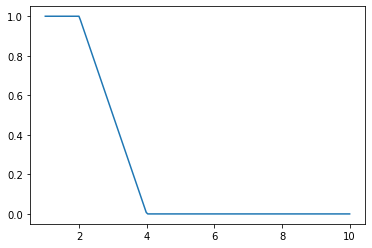

In [ ]:
lf = LinearFuzzifier([1, 2, 5, 5.5, 7, 8, 9.5, 10],
                    [1, 1, 1, 0.9, 0.4, 0.1, 0, 0])
[mu] = lf.get_membership(1, lambda x: x/3)

x = np.linspace(1, 10, 200)
plt.plot(x, list(map(mu, x)))
plt.show()

Setting `profile='infer'` will perform an interpolation process fitting
the membership slope to the training set passed to the constructor.

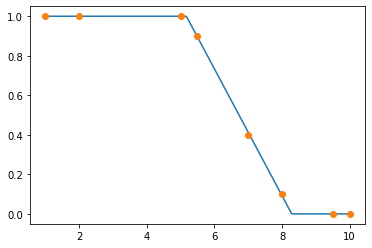

In [ ]:
xs = [1, 2, 5, 5.5, 7, 8, 9.5, 10]
mus = [1, 1, 1, 0.9, 0.4, 0.1, 0, 0]
lf = LinearFuzzifier(xs,mus, profile='infer')
[mu] = lf.get_membership(2, lambda x: x/3)

x = np.linspace(1, 10, 200)
plt.plot(x, list(map(mu, x)))
plt.plot(xs, mus, 'o')
plt.show()

The `return_profile` optional argument returns a further list that contains
- a list of the squared distances between the images of points in the
  training set and the center of the sphere;
- a list of synthesized values for such distances (spanned uniformely
  between the minimum and maximum values of the distances within the
  training set);
- a list of membership values associated to the values in previous point.

This new information allow for drawing a profile of the membership function
as a function of the distance in feature space.

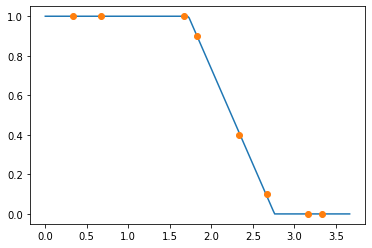

In [ ]:
[mu, [rdata, rdata_synth, estimate]] = \
      lf.get_membership(1, lambda x: x/3, return_profile=True)

plt.plot(rdata_synth, estimate)
plt.plot(rdata, mus, 'o')
plt.show()

**Tests**

In [ ]:
with pytest.raises(ValueError):
    lf = LinearFuzzifier(profile='infer')
    
with pytest.raises(ValueError):
    lr = LinearFuzzifier(profile='xxx')

In [ ]:
#export
class ExponentialFuzzifier(Fuzzifier):
    def __init__(self, xs=None, mus=None,
                 profile='fixed', alpha=None, sample=None):
        r'''Creates an instance of `ExponentialFuzzifier`
        
        - `xs`: objects in training set (iterable).
        
        - `mus`: degree memberships in training set (iterable).
        
        - `profile`: method to be used in order to fix the exponential
          decay ('fixed' used the sphere radius, 'infer' fits using
          data in `self.xs` and `self.mus`, and `alpha` relies on a
          manually set `alpha` parameter).
          
        - `alpha`: decaying degree of the exponential (float in (0, 1)).
        '''
        
        super().__init__(xs, mus)
        
        if profile not in ['infer', 'fixed', 'alpha']:
            raise ValueError(f"'profile' parameter should be equal to "
                             "'infer', 'fixed' or 'alpha' "
                             "(provided value: {profile})")
            
        if profile == 'infer' and (xs is None or mus is None):
            raise ValueError(f"arguments xs and mus to the constructor of "
                             "ExponentialFuzzifier should be specified when "
                             "profile='infer'")
        
        if profile == 'alpha':
            if alpha is None:
                raise ValueError("alpha must be set to a float when"
                                 "'profile' is 'alpha'")
            if alpha <= 0 or alpha >= 1:
                raise ValueError("alpha must belong to (0, 1)"
                                 "'profile' is 'alpha'")
            self.name = f'Exponential({alpha})'
            self.latex_name = \
                      r'$\hat\mu_{{\text{{exp}},{:.3f}}}$'.format(alpha)
            
            self.alpha = alpha
        else:
            self.name = 'Exponential'
            self.latex_name = r'$\hat\mu_{\text{nexp}}$'
        
        self.profile = profile
        
        self.sample = sample


    def get_r_to_mu(self,
                    sq_radius, # was SV_square_distance
                    x_to_sq_dist): #was estimated_square_distance_from_center
        r'''Returns a function that transforms the square distance between
        center of the learnt sphere and the image of a point in original
        space into a membership degree having the form
        
        $$ \mu(r) = \begin{cases}
          1    & \text{if $r \leq r_\text{crisp}$,} \\
          e(r) & \text{otherwise,}
        \end{cases}$$   
        
        where $e$ is an exponential function decreasing from 1 to 0. The
        shape of this function is chosen so that the latter contains the
        point (sq_radius, 0.5) if the `profile` attribute of the class
        have been set to `fixed`, induced via interpolation of the `xs`
        and `mus` attributes when it is has been set to `infer`, and
        manually set via the `alpha` parameter of the constructor when
        `profile='alpha'`.
        
        **Note** This function is meant to be called internally by the
        `get_membership` method in the base `Fuzzifier` class.
        
        - `sq_radius`: squared radius of the learnt sphere (float).
        
        - `x_to_sq_dist`: mapping of a point in original space into the
          square distance of its image from the center of the learnt sphere
          (function).
        '''

        r_1_guess = np.median([x_to_sq_dist(x)
                               for x, mu in zip(self.xs, self.mus)
                               if mu>=0.99])
        
        s_guess = (sq_radius - r_1_guess) / np.log(2)

        rdata = np.fromiter(map(x_to_sq_dist, self.xs), dtype=float)

        if self.profile == 'fixed':
            def r_to_mu_prototype(r, r_1):    
                return [np.clip(np.exp(-(rr-r_1)/(sq_radius-r_1) * np.log(2)),
                                0, 1) for rr in r]

            popt, _ = curve_fit(r_to_mu_prototype, rdata, self.mus,
                                p0=(r_1_guess,))
                                #bounds=((0,), (np.inf,)))
            return lambda r: r_to_mu_prototype([r], *popt)[0]

        elif self.profile == 'infer':
            def r_to_mu_prototype(r, r_1, s):
                return [np.clip(np.exp(-(rr - r_1) / s), 0, 1) for rr in r]

            popt, _ = curve_fit(r_to_mu_prototype, rdata, self.mus,
                                #p0=(r_1_guess, s_guess),
                                bounds=((0, 0), (np.inf, np.inf)))

            return lambda r: r_to_mu_prototype([r], *popt)[0]

        elif self.profile == 'alpha':
            r_sample = map(x_to_sq_dist, self.sample \
                            if self.sample is not None else self.xs)

            q = np.percentile([s - sq_radius for s in r_sample
                                             if s > sq_radius],
                              100*self.alpha)

            return lambda r: np.clip(np.exp(np.log(self.alpha)/q * (r - sq_radius)),
                           0, 1)
        else:
            raise ValueError('This should not happen. Check the constructor')
    
    def __repr__(self):
        xs_repr = self.xs.__repr__()
        mus_repr = self.mus.__repr__()
        self_repr = f'ExponentialFuzzifier({xs_repr}, {mus_repr}'
        if self.profile != 'fixed':
            self_repr += f', profile={self.profile}'
        if self.alpha is not None:
            self_repr += f', alpha={self.alpha}'
        if self.sample is not None:
            self_repr += f', sample={self.sample.__repr__()}'
        self_repr += ')'
        return self_repr


Fuzzifier corresponding to a fuzzy set whose membership exponentially
decreases from 1 to 0.

In [ ]:
show_doc(ExponentialFuzzifier.__init__)

<h4 id="ExponentialFuzzifier.__init__" class="doc_header"><code>ExponentialFuzzifier.__init__</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>ExponentialFuzzifier.__init__</code>(**`xs`**=*`None`*, **`mus`**=*`None`*, **`profile`**=*`'fixed'`*, **`alpha`**=*`None`*, **`sample`**=*`None`*)

Creates an instance of [`ExponentialFuzzifier`](/mulearn/fuzzifiers#ExponentialFuzzifier)

- `xs`: objects in training set (iterable).

- `mus`: degree memberships in training set (iterable).

- `profile`: method to be used in order to fix the exponential
  decay ('fixed' used the sphere radius, 'infer' fits using
  data in `self.xs` and `self.mus`, and `alpha` relies on a
  manually set `alpha` parameter).
  
- `alpha`: decaying degree of the exponential (float in (0, 1)).

Aa exponential fuzzifier can be created etiher without arguments or specifying
objects and labels of a training set.

In [ ]:
ef_1 = ExponentialFuzzifier()
ef_2 = ExponentialFuzzifier([1, 2, 5, 5.5, 7, 8, 9.5, 10],
                      [1, 1, 1, 0.9, 0.4, 0.1, 0, 0])

The optional parameter `profile` defines the procedure to be used in order
to choose the thresholding value in the fuzzifier, it can either be set to
`'fixed'`, `'infer'`, or `'alpha'` (see the description of
`get_membership` later on).
Specifying a different value will raise an exception. The same will happen
if `profile='infer'` and the training set has not been specified as argument
to the constructor, or if `profile='alpha'` and the `alpha` parameter has not
been specified, or if a value not belonging to (0, 1) has been specified.

In [ ]:
show_doc(ExponentialFuzzifier.get_r_to_mu)

<h4 id="ExponentialFuzzifier.get_r_to_mu" class="doc_header"><code>ExponentialFuzzifier.get_r_to_mu</code><a href="__main__.py#L52" class="source_link" style="float:right">[source]</a></h4>

> <code>ExponentialFuzzifier.get_r_to_mu</code>(**`sq_radius`**, **`x_to_sq_dist`**)

Returns a function that transforms the square distance between
center of the learnt sphere and the image of a point in original
space into a membership degree having the form

$$ \mu(r) = \begin{cases}
  1    & \text{if $r \leq r_\text{crisp}$,} \\
  e(r) & \text{otherwise,}
\end{cases}$$   

where $e$ is an exponential function decreasing from 1 to 0. The
shape of this function is chosen so that the latter contains the
point (sq_radius, 0.5) if the `profile` attribute of the class
have been set to `fixed`, induced via interpolation of the `xs`
and `mus` attributes when it is has been set to `infer`, and
manually set via the `alpha` parameter of the constructor when
`profile='alpha'`.

**Note** This function is meant to be called internally by the
`get_membership` method in the base [`Fuzzifier`](/mulearn/fuzzifiers#Fuzzifier) class.

- `sq_radius`: squared radius of the learnt sphere (float).

- `x_to_sq_dist`: mapping of a point in original space into the
  square distance of its image from the center of the learnt sphere
  (function).

In [ ]:
show_doc(ExponentialFuzzifier.get_membership)

<h4 id="Fuzzifier.get_membership" class="doc_header"><code>Fuzzifier.get_membership</code><a href="__main__.py#L27" class="source_link" style="float:right">[source]</a></h4>

> <code>Fuzzifier.get_membership</code>(**`sq_radius`**, **`x_to_sq_dist`**, **`return_profile`**=*`False`*)

Return the induced membership function.

- `sq_radius`: squared radius of the learnt sphere (float).

- `x_to_sq_dist`: mapping of a point in original space into the
  square distance of its image from the center of the learnt sphere
  (function).

- `return_profile` flag triggering the generation of the graph
  of the fuzzifier to be returned alongside the fuzzifier itself
  (bool, default=False).

Returns a list containing

- the membership function if `return_profile` is `False`, and
- the membership function and the salient coordinates of the graph of
  the fuzzifier if `return_profile` is `True`.

`ExponentialFuzzifier` implements this method in order to return an
exponentially decreasing function, whose slope is fixed by default so that
the membership value 0.5 corresponds to the radius of the learnt sphere.

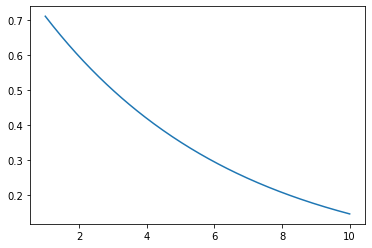

In [ ]:
xs = [1, 2, 5, 5.5, 7, 8, 9.5, 10]
mus = [1, 1, 1, 0.9, 0.4, 0.1, 0, 0]

f = ExponentialFuzzifier(xs, mus)
[mu] = f.get_membership(1, lambda x: x/3)

x = np.linspace(1, 10, 200)
plt.plot(x, list(map(mu, x)))
plt.show()

Setting `profile='infer'` will perform an interpolation process fitting
the membership slope to the training set passed to the constructor.

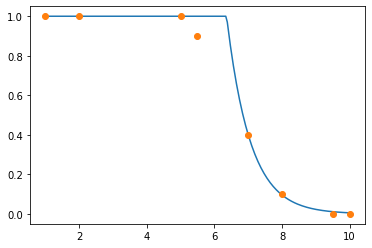

In [ ]:
f = ExponentialFuzzifier(xs,mus, profile='infer')
[mu] = f.get_membership(2, lambda x: x/3)

plt.plot(x, list(map(mu, x)))
plt.plot(xs, mus, 'o')
plt.show()

Setting `profile='alpha'` allows to manually define the decay rate using
the `alpha` argument, which is 

$$
\hat\mu_{\text{exp},\alpha}(x) = \begin{cases}
                                   1 & \text{if $R(x) \leq R_1$} \\
                                   \mathrm{exp}\left( \frac{\ln \alpha}{q_{\alpha}}
                                   \left(r - R_1\right) \right) & \text{otherwise},
                                 \end{cases}
$$

being $q_\alpha$ the $\alpha$-quantile of the observed data.

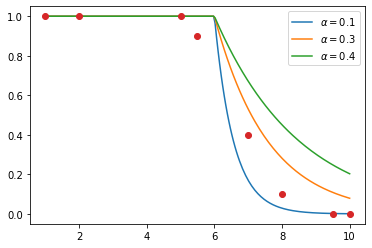

In [ ]:
for alpha in (0.1, 0.3, 0.4):
    f = ExponentialFuzzifier(xs,mus, profile='alpha', alpha=alpha)
    [mu] = f.get_membership(2, lambda x: x/3)
    plt.plot(x, list(map(mu, x)), label=fr'$\alpha = {alpha}$')

plt.plot(xs, mus, 'o')
plt.legend()
plt.show()

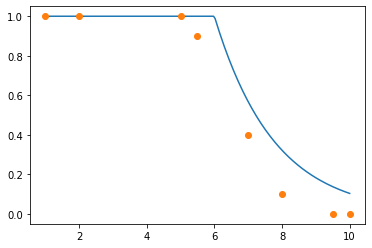

In [ ]:
s = np.random.uniform(0, 10, size=100)

f = ExponentialFuzzifier(xs,mus, profile='alpha', alpha=alpha, sample=s)
[mu] = f.get_membership(2, lambda x: x/3)
plt.plot(x, list(map(mu, x)), label=fr'$\alpha = {alpha}$')
plt.plot(xs, mus, 'o')
plt.show()

The `return_profile` optional argument returns a further list that contains
- a list of the squared distances between the images of points in the
  training set and the center of the sphere;
- a list of synthesized values for such distances (spanned uniformely
  between the minimum and maximum values of the distances within the
  training set);
- a list of membership values associated to the values in previous point.

This new information allow for drawing a profile of the membership function
as a function of the distance in feature space.

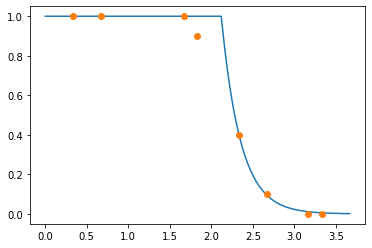

In [ ]:
f = ExponentialFuzzifier(xs,mus, profile='infer')

[mu, [rdata, rdata_synth, estimate]] = \
      f.get_membership(1, lambda x: x/3, return_profile=True)

plt.plot(rdata_synth, estimate)
plt.plot(rdata, mus, 'o')
plt.show()

**Tests**

In [ ]:
with pytest.raises(ValueError):
    f = ExponentialFuzzifier(profile='infer')
    
with pytest.raises(ValueError):
    r = ExponentialFuzzifier(profile='xxx')

In [ ]:
#export

class QuantileConstantPiecewiseFuzzifier(Fuzzifier):
    def __init__(self, xs=None, mus=None, sample=None):
        r'''Creates an instance of `QuantileConstantPiecewiseFuzzifier`
        
        - `xs`: objects in training set (iterable).
        
        - `mus`: degree memberships in training set (iterable).
          
        - `sample`: sample to be used in order to build quantile instead of
          training set.
        '''
        
        super().__init__(xs, mus)
        
        if sample is None and xs is None:
            raise ValueError(f"either the xs or sample argument of the "
                             "constructor of "
                             "QuantileConstantPiecewiseFuzzifier should be "
                             "specified")
        
        self.sample = sample
        
        self.name = 'QuantileConstPiecewise'
        self.latex_name = '$\\hat\\mu_{\\text{qconst}}$'
        
        
    def get_r_to_mu(self,
                    sq_radius, # was SV_square_distance
                    x_to_sq_dist): #was estimated_square_distance_from_center
        r'''Returns a function that transforms the square distance between
        center of the learnt sphere and the image of a point in original
        space into a constant piecewise membership degree whose steps
        are chosen according to the quartiles of square distances between
        images of points and center of the learnt sphere.
        
        **Note** This function is meant to be called internally by the
        `get_membership` method in the base `Fuzzifier` class.
        
        - `sq_radius`: squared radius of the learnt sphere (float).
        
        - `x_to_sq_dist`: mapping of a point in original space into the
          square distance of its image from the center of the learnt sphere
          (function).
        '''
        
        r_sample = np.fromiter(map(x_to_sq_dist, self.sample \
                      if self.sample is not None else self.xs), dtype=float)
        external_dist = [s-sq_radius
                         for s in r_sample if s > sq_radius]
        
        if external_dist:
            m = np.median(external_dist)
            q1 = np.percentile(external_dist, 25)
            q3 = np.percentile(external_dist, 75)
        else:
            m = q1 = q3 = 0

        def r_to_mu(r):
            return 1 if r <= sq_radius \
                     else 0.75 if r <= sq_radius + q1 \
                     else 0.5 if r <= sq_radius + m \
                     else 0.25 if r <= sq_radius + q3 \
                     else 0

        return r_to_mu

    def __repr__(self):
        return 'QuantileConstantPiecewiseFuzzifier({}, {})'.format(self.xs, self.mus)
        self_repr = 'QuantileConstantPiecewiseFuzzifier('
        xs_repr = self.xs.__repr__()
        mus_repr = self.mus.__repr__()
        self_repr += f'{xs_repr}, {mus_repr}'
        if self.sample is not None:
            self_repr += f', sample={self.sample.__repr__()}'
        self_repr += ')'
        return self_repr

Fuzzifier corresponding to a fuzzy set with a piecewise constant membership
function, whose steps are defined according to the quartiles of the squared
distances between images of points and center of the learng sphere.

In [ ]:
show_doc(QuantileConstantPiecewiseFuzzifier.__init__)

<h4 id="QuantileConstantPiecewiseFuzzifier.__init__" class="doc_header"><code>QuantileConstantPiecewiseFuzzifier.__init__</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>QuantileConstantPiecewiseFuzzifier.__init__</code>(**`xs`**=*`None`*, **`mus`**=*`None`*, **`sample`**=*`None`*)

Creates an instance of [`QuantileConstantPiecewiseFuzzifier`](/mulearn/fuzzifiers#QuantileConstantPiecewiseFuzzifier)

- `xs`: objects in training set (iterable).

- `mus`: degree memberships in training set (iterable).
  
- `sample`: sample to be used in order to build quantile instead of
  training set.

A piecewise constant fuzzifier can be created specifying either
objects and labels of a training set or a sample of objects.

In [ ]:
f = QuantileConstantPiecewiseFuzzifier([1, 2, 5, 5.5, 7, 8, 9.5, 10],
                                       [1, 1, 1, 0.9, 0.4, 0.1, 0, 0])
f = QuantileConstantPiecewiseFuzzifier(sample=[1, 2, 5, 5.5, 7, 8, 9.5, 10])

The optional parameter `sample` defines the data to be used in order
to compute quartiles defining the steps of the piecewise membership, as an
alternative to the ones in the training set.

In [ ]:
show_doc(QuantileConstantPiecewiseFuzzifier.get_r_to_mu)

<h4 id="QuantileConstantPiecewiseFuzzifier.get_r_to_mu" class="doc_header"><code>QuantileConstantPiecewiseFuzzifier.get_r_to_mu</code><a href="__main__.py#L29" class="source_link" style="float:right">[source]</a></h4>

> <code>QuantileConstantPiecewiseFuzzifier.get_r_to_mu</code>(**`sq_radius`**, **`x_to_sq_dist`**)

Returns a function that transforms the square distance between
center of the learnt sphere and the image of a point in original
space into a constance piecewise membership degree whose steps
are chosen according to the quartiles of square distances between
images of points and center of the learnt sphere.

**Note** This function is meant to be called internally by the
`get_membership` method in the base [`Fuzzifier`](/mulearn/fuzzifiers#Fuzzifier) class.

- `sq_radius`: squared radius of the learnt sphere (float).

- `x_to_sq_dist`: mapping of a point in original space into the
  square distance of its image from the center of the learnt sphere
  (function).

In [ ]:
show_doc(QuantileConstantPiecewiseFuzzifier.get_membership)

<h4 id="Fuzzifier.get_membership" class="doc_header"><code>Fuzzifier.get_membership</code><a href="__main__.py#L27" class="source_link" style="float:right">[source]</a></h4>

> <code>Fuzzifier.get_membership</code>(**`sq_radius`**, **`x_to_sq_dist`**, **`return_profile`**=*`False`*)

Return the induced membership function.

- `sq_radius`: squared radius of the learnt sphere (float).

- `x_to_sq_dist`: mapping of a point in original space into the
  square distance of its image from the center of the learnt sphere
  (function).

- `return_profile` flag triggering the generation of the graph
  of the fuzzifier to be returned alongside the fuzzifier itself
  (bool, default=False).

Returns a list containing

- the membership function if `return_profile` is `False`, and
- the membership function and the salient coordinates of the graph of
  the fuzzifier if `return_profile` is `True`.

`QuantileConstantPiecewiseFuzzifier` implements this method in order to
return a piecewise constant decreasing function, whose steps are fixed
according to the quartiles of the distances between the images of points
and the center of the learnt sphere.

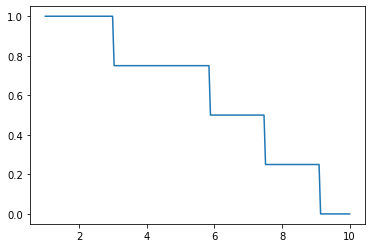

In [ ]:
xs = [1, 2, 5, 5.5, 7, 8, 9.5, 10]
mus = [1, 1, 1, 0.9, 0.4, 0.1, 0, 0]

f = QuantileConstantPiecewiseFuzzifier(xs, mus)
[mu] = f.get_membership(1, lambda x: x/3)

x = np.linspace(1, 10, 200)
plt.plot(x, list(map(mu, x)))
plt.show()

The `sample` argument of the constructor allow to specify a different sample
in order to compute quartile.

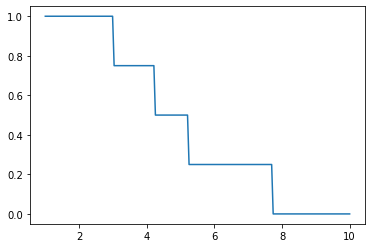

In [ ]:
f = QuantileConstantPiecewiseFuzzifier(sample=np.random.uniform(0, 10,
                                                                size=100))
[mu] = f.get_membership(1, lambda x: x/3)

plt.plot(x, list(map(mu, x)))
plt.show()

The `return_profile` optional argument returns a further list that contains
- a list of the squared distances between the images of points in the
  training set and the center of the sphere;
- a list of synthesized values for such distances (spanned uniformely
  between the minimum and maximum values of the distances within the
  training set);
- a list of membership values associated to the values in previous point.

This new information allow for drawing a profile of the membership function
as a function of the distance in feature space.

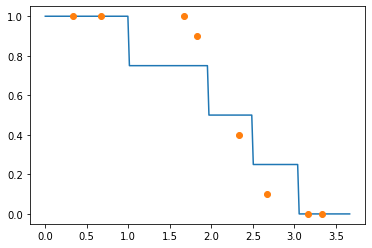

In [ ]:
f = QuantileConstantPiecewiseFuzzifier(xs,mus)

[mu, [rdata, rdata_synth, estimate]] = \
      f.get_membership(1, lambda x: x/3, return_profile=True)

plt.plot(rdata_synth, estimate)
plt.plot(rdata, mus, 'o')
plt.show()

**Tests**

In [ ]:
with pytest.raises(ValueError):
    f = QuantileConstantPiecewiseFuzzifier()

In [ ]:
#export

class QuantileLinearPiecewiseFuzzifier(Fuzzifier):
    def __init__(self, xs=None, mus=None, sample=None):
        r'''Creates an instance of `QuantileLinearPiecewiseFuzzifier`
        
        - `xs`: objects in training set (iterable).
        
        - `mus`: degree memberships in training set (iterable).
          
        - `sample`: sample to be used in order to build quantile instead of
          training set.
        '''
        
        super().__init__(xs, mus)
        
        if sample is None and xs is None:
            raise ValueError(f"either the xs or sample argument of the "
                             "constructor of "
                             "QuantileLinearPiecewiseFuzzifier should be "
                             "specified")
            
        self.sample = sample
        
        self.name = 'QuantileLinPiecewise'
        self.latex_name = '$\\hat\\mu_{\\text{qlin}}$'


    def get_r_to_mu(self,
                    sq_radius, # was SV_square_distance
                    x_to_sq_dist): #was estimated_square_distance_from_center
        r'''Returns a function that transforms the square distance between
        center of the learnt sphere and the image of a point in original
        space into a linear piecewise membership degree whose steps
        are chosen according to the quartiles of square distances between
        images of points and center of the learnt sphere.
        
        **Note** This function is meant to be called internally by the
        `get_membership` method in the base `Fuzzifier` class.
        
        - `sq_radius`: squared radius of the learnt sphere (float).
        
        - `x_to_sq_dist`: mapping of a point in original space into the
          square distance of its image from the center of the learnt sphere
          (function).
        '''
        
        r_sample = np.fromiter(map(x_to_sq_dist, self.sample \
                      if self.sample is not None else self.xs), dtype=float)
        
        external_dist = [s-sq_radius
                         for s in r_sample if s > sq_radius]
        if external_dist:
            m = np.median(external_dist)
            q1 = np.percentile(external_dist, 25)
            q3 = np.percentile(external_dist, 75)
            mx = np.max(r_sample) - sq_radius
        else:
            m = q1 = q3 = mx = 0

        def r_to_mu(r):
            ssd = sq_radius
            return 1 if r <= ssd \
                 else (-r + ssd)/(4*q1) + 1 if r <= ssd + q1 \
                 else (-r + ssd + q1)/(4*(m-q1)) + 3.0/4 if r <= ssd + m \
                 else (-r + ssd + m)/(4*(q3-m)) + 1./2 if r <= ssd + q3 \
                 else (-r + ssd + q3)/(4*(mx-q3)) + 1./4 if r <= ssd+mx \
                 else 0

        return r_to_mu

    def __repr__(self):
        return 'QuantileLinearPiecewiseFuzzifier({}, {})'.format(self.xs, self.mus)


Fuzzifier corresponding to a fuzzy set with a linear constant membership
function, whose steps are defined according to the quartiles of the squared
distances between images of points and center of the learng sphere.

In [ ]:
show_doc(QuantileLinearPiecewiseFuzzifier.__init__)

<h4 id="QuantileLinearPiecewiseFuzzifier.__init__" class="doc_header"><code>QuantileLinearPiecewiseFuzzifier.__init__</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>QuantileLinearPiecewiseFuzzifier.__init__</code>(**`xs`**=*`None`*, **`mus`**=*`None`*, **`sample`**=*`None`*)

Creates an instance of `QuantileLinearPiecewiseFuzzifier`

- `xs`: objects in training set (iterable).

- `mus`: degree memberships in training set (iterable).
  
- `sample`: sample to be used in order to build quantile instead of
  training set.

A linear constant fuzzifier can be created specifying either
objects and labels of a training set or a sample of objects.

In [ ]:
f = QuantileLinearPiecewiseFuzzifier([1, 2, 5, 5.5, 7, 8, 9.5, 10],
                                       [1, 1, 1, 0.9, 0.4, 0.1, 0, 0])
f = QuantileLinearPiecewiseFuzzifier(sample=[1, 2, 5, 5.5, 7, 8, 9.5, 10])

The optional parameter `sample` defines the data to be used in order
to compute quartiles defining the steps of the piecewise membership, as an
alternative to the ones in the training set.

In [ ]:
show_doc(QuantileLinearPiecewiseFuzzifier.get_r_to_mu)

<h4 id="QuantileLinearPiecewiseFuzzifier.get_r_to_mu" class="doc_header"><code>QuantileLinearPiecewiseFuzzifier.get_r_to_mu</code><a href="__main__.py#L29" class="source_link" style="float:right">[source]</a></h4>

> <code>QuantileLinearPiecewiseFuzzifier.get_r_to_mu</code>(**`sq_radius`**, **`x_to_sq_dist`**)

Returns a function that transforms the square distance between
center of the learnt sphere and the image of a point in original
space into a linear piecewise membership degree whose steps
are chosen according to the quartiles of square distances between
images of points and center of the learnt sphere.

**Note** This function is meant to be called internally by the
`get_membership` method in the base [`Fuzzifier`](/mulearn/fuzzifiers#Fuzzifier) class.

- `sq_radius`: squared radius of the learnt sphere (float).

- `x_to_sq_dist`: mapping of a point in original space into the
  square distance of its image from the center of the learnt sphere
  (function).

In [ ]:
show_doc(QuantileLinearPiecewiseFuzzifier.get_membership)

<h4 id="Fuzzifier.get_membership" class="doc_header"><code>Fuzzifier.get_membership</code><a href="__main__.py#L27" class="source_link" style="float:right">[source]</a></h4>

> <code>Fuzzifier.get_membership</code>(**`sq_radius`**, **`x_to_sq_dist`**, **`return_profile`**=*`False`*)

Return the induced membership function.

- `sq_radius`: squared radius of the learnt sphere (float).

- `x_to_sq_dist`: mapping of a point in original space into the
  square distance of its image from the center of the learnt sphere
  (function).

- `return_profile` flag triggering the generation of the graph
  of the fuzzifier to be returned alongside the fuzzifier itself
  (bool, default=False).

Returns a list containing

- the membership function if `return_profile` is `False`, and
- the membership function and the salient coordinates of the graph of
  the fuzzifier if `return_profile` is `True`.

`QuantileLinearPiecewiseFuzzifier` implements this method in order to
return a piecewise linear decreasing function, whose steps are fixed
according to the quartiles of the distances between the images of points
and the center of the learnt sphere.

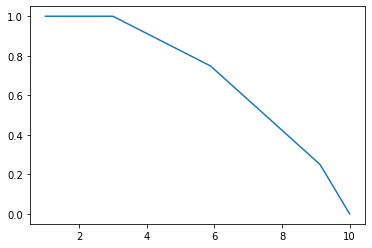

In [ ]:
xs = [1, 2, 5, 5.5, 7, 8, 9.5, 10]
mus = [1, 1, 1, 0.9, 0.4, 0.1, 0, 0]

f = QuantileLinearPiecewiseFuzzifier(xs, mus)
[mu] = f.get_membership(1, lambda x: x/3)

x = np.linspace(1, 10, 200)
plt.plot(x, list(map(mu, x)))
plt.show()

The `sample` argument of the constructor allow to specify a different sample
in order to compute quartile.

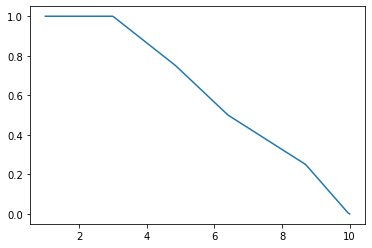

In [ ]:
f = QuantileLinearPiecewiseFuzzifier(sample=np.random.uniform(0, 10,
                                                              size=100))
[mu] = f.get_membership(1, lambda x: x/3)

plt.plot(x, list(map(mu, x)))
plt.show()

The `return_profile` optional argument returns a further list that contains
- a list of the squared distances between the images of points in the
  training set and the center of the sphere;
- a list of synthesized values for such distances (spanned uniformely
  between the minimum and maximum values of the distances within the
  training set);
- a list of membership values associated to the values in previous point.

This new information allow for drawing a profile of the membership function
as a function of the distance in feature space.

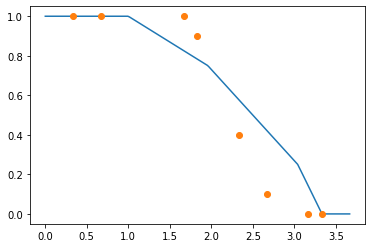

In [ ]:
f = QuantileLinearPiecewiseFuzzifier(xs,mus)

[mu, [rdata, rdata_synth, estimate]] = \
      f.get_membership(1, lambda x: x/3, return_profile=True)

plt.plot(rdata_synth, estimate)
plt.plot(rdata, mus, 'o')
plt.show()

**Tests**

In [ ]:
with pytest.raises(ValueError):
    f = QuantileLinearPiecewiseFuzzifier()